In [138]:
import os
import pandas as pd

tsv_file = r"C:\Users\parth\Downloads\cv-corpus-13.0-delta-2023-03-09\en\validated.tsv"
df = pd.read_csv(tsv_file, sep='\t', header=None)
filtered_df = df[df[6].isin(["male", "female"])]

In [139]:
paths = []
for i in filtered_df[1][1:]:
    path = r"C:\Users\parth\Downloads\cv-corpus-13.0-delta-2023-03-09\en\clips\\" + str(i)
    path = path.replace("\\\\", "\\")  # Replace double backslashes with a single backslash
    paths.append(path)

# Check if each path exists in the clip directory and add the first 1000 valid clips to a new list
count = 0
new_mp3_paths = []
genders = []  # Store the gender of each clip
for path in paths:
    if os.path.exists(path):
        new_mp3_paths.append(path)  # Store the full path
        genders.append(filtered_df[6].iloc[count+1])  # Get the gender from the original DataFrame
        count += 1
        if count == 1000:
            break

# Create a new DataFrame for the first 1000 valid clips with full paths, genders, and clip names
new_df = pd.DataFrame({"File Name": [os.path.basename(path) for path in new_mp3_paths], "Gender": genders})
new_df

,File Name,Gender
0,common_voice_en_36951323.mp3,male
1,common_voice_en_37251984.mp3,female
2,common_voice_en_37028857.mp3,female
3,common_voice_en_37016755.mp3,female
4,common_voice_en_37153340.mp3,male
...,...,...
995,common_voice_en_36886952.mp3,male
996,common_voice_en_36886958.mp3,male
997,common_voice_en_36886984.mp3,male
998,common_voice_en_36887028.mp3,male


In [99]:
import librosa
from pydub import AudioSegment

def extract_features(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Extract acoustic features
    pitch = librosa.piptrack(y=y, sr=sr)[0]  # Pitch estimation
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
    spectral_entropy = librosa.feature.spectral_flatness(y=y)
    energy = librosa.feature.rms(y=y)
    duration = librosa.get_duration(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

    # Calculate mean values for some features
    mean_pitch = pitch.mean()
    mean_spectral_centroid = spectral_centroid.mean()
    mean_spectral_rolloff = spectral_rolloff.mean()
    mean_spectral_flux = spectral_flux.mean()
    mean_spectral_entropy = spectral_entropy.mean()
    mean_energy = energy.mean()
    mean_zero_crossing_rate = zero_crossing_rate.mean()

    # Create a dictionary to store the features
    features = {
        "Audio File": audio_file,
        "Pitch Mean": mean_pitch,
        "Spectral Centroid Mean": mean_spectral_centroid,
        "Spectral Rolloff Mean": mean_spectral_rolloff,
        "Spectral Flux Mean": mean_spectral_flux,
        "Spectral Entropy Mean": mean_spectral_entropy,
        "Energy Mean": mean_energy,
        "Duration": duration,
        "Zero Crossing Rate Mean": mean_zero_crossing_rate,
    }

    # Add MFCCs features
    for i in range(13):
        features[f"MFCC{i+1} Mean"] = mfccs[i].mean()

    return features

In [140]:
feature_list = []

# Iterate through the list of file paths
for mp3_file_path in new_mp3_paths[:1000]:
    # Convert MP3 to WAV using pydub
    audio = AudioSegment.from_mp3(mp3_file_path)
    wav_file_path = mp3_file_path.replace(".mp3", ".wav")
    audio.export(wav_file_path, format="wav")

    # Extract features from the WAV file
    features = extract_features(wav_file_path)
    feature_list.append(features)
    
# Create a Pandas DataFrame from the feature list
features_df = pd.DataFrame(feature_list)


In [149]:
final_df = pd.concat([features_df, new_df], axis=1)
final_df = final_df.drop('Audio File', axis=1)
final_df = final_df.drop('File Name', axis=1)

# Map "male" to 1 and "female" to 0 in the "Gender" column
final_df['Gender'] = final_df['Gender'].replace({'male': 1, 'female': 0})

final_df

,Pitch Mean,Spectral Centroid Mean,Spectral Rolloff Mean,Spectral Flux Mean,Spectral Entropy Mean,Energy Mean,Duration,Zero Crossing Rate Mean,MFCC1 Mean,MFCC2 Mean,...,MFCC5 Mean,MFCC6 Mean,MFCC7 Mean,MFCC8 Mean,MFCC9 Mean,MFCC10 Mean,MFCC11 Mean,MFCC12 Mean,MFCC13 Mean,Gender
0,20.776913,2289.621351,4369.477730,1.879460,0.017042,0.041735,6.516009,0.133773,-382.148743,92.967888,...,21.569263,-1.002082,-2.327993,-19.122477,-1.823463,6.872465,-6.616433,-6.807905,7.173785,1
1,33.207699,2513.333266,4639.024940,2.094928,0.041278,0.037318,7.236009,0.156871,-371.446655,77.048210,...,-10.596306,-8.170298,-13.579588,-1.596864,-5.601696,6.566207,-10.420648,-3.865748,0.917314,0
2,22.911053,2575.063845,4568.793963,1.997294,0.020029,0.047067,6.516009,0.157984,-385.238220,62.018162,...,-0.043410,3.970614,-15.983755,-14.426505,-2.868516,-1.306147,-4.982901,-11.172515,-6.014668,0
3,39.814262,2228.561281,3760.552794,2.184345,0.011212,0.079487,6.876009,0.170977,-337.726288,77.180412,...,-24.669296,-1.185048,-10.104847,-11.100657,-9.824773,-6.192679,-12.532792,-10.597467,-3.337687,0
4,52.416439,2255.242560,4410.205078,1.679188,0.028791,0.032567,8.280000,0.177656,-362.354950,92.825447,...,-32.564251,21.396814,-21.936625,-8.051341,-6.237684,-17.639999,-0.782456,-7.530823,-2.599679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44.972687,1879.425345,3475.458984,1.645491,0.028519,0.046536,7.308027,0.215182,-395.413055,81.344002,...,5.893445,1.792608,-10.579489,-18.065069,-10.203231,-6.320141,-1.348113,-5.197655,2.874732,1
996,39.232620,1547.858786,2824.531998,1.531213,0.022183,0.047676,7.128027,0.162773,-383.029663,89.459846,...,10.845136,-4.128807,-11.592266,-17.093538,-14.112931,-6.485637,-1.910442,-6.524463,0.979369,1
997,41.396503,2131.363184,3790.351267,1.607266,0.018120,0.037006,6.876009,0.196329,-396.696228,55.029644,...,3.704308,5.859227,-10.928280,-17.370026,-10.888808,-4.671909,-2.225273,-10.697608,4.100216,1
998,49.134972,1814.830039,3361.832328,1.206230,0.034426,0.048956,6.408027,0.223884,-428.171448,77.567596,...,-11.349295,-7.022431,-6.854762,-12.910546,-10.176740,-2.213851,-0.171738,-6.653764,2.393035,1


In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into features (X) and target (y)
X = final_df.drop('Gender', axis=1)  # Features
y = final_df['Gender']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier (you can use other classifiers as well)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 87.50%


In [151]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[ 39  19]
 [  6 136]]


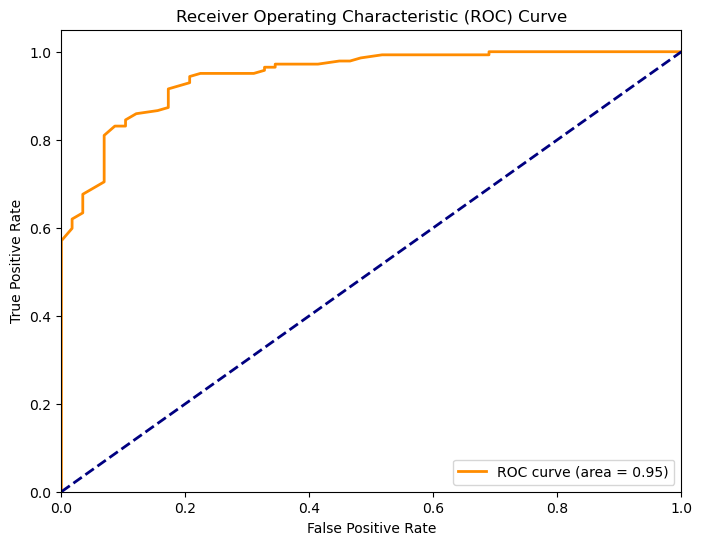

In [152]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate the ROC curve
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
